## Import Libraries

In [ ]:
# Handling Data
import pandas as pd
import numpy as np

# Visialization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# For Text processing 
import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

# ML
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# DL
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv1D, Dense, MaxPooling1D, BatchNormalization, Flatten, Dropout
from tensorflow.keras.models import Sequential

#Accuracy Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Reading Data

In [ ]:
df = pd.read_csv('/content/spam_ham_dataset.csv')
# Removing Unnecessary column
df.drop('Unnamed: 0', axis=1, inplace = True)
# Changing column names
df.columns = ['label', 'text', 'class']

In [ ]:
df.head()

,label,text,class
0,ham,Subject: enron methanol ; meter # : 988291\r\n...,0
1,ham,"Subject: hpl nom for january 9 , 2001\r\n( see...",0
2,ham,"Subject: neon retreat\r\nho ho ho , we ' re ar...",0
3,spam,"Subject: photoshop , windows , office . cheap ...",1
4,ham,Subject: re : indian springs\r\nthis deal is t...,0


In [ ]:
df.shape

(5171, 3)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5171 entries, 0 to 5170
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5171 non-null   object
 1   text    5171 non-null   object
 2   class   5171 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 121.3+ KB


In [ ]:
df.isna().sum()

label    0
text     0
class    0
dtype: int64

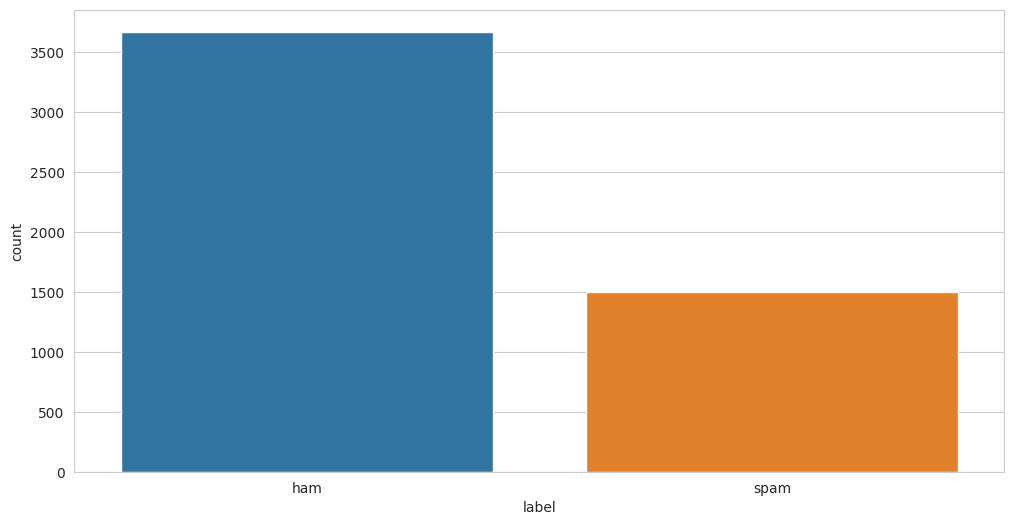

In [ ]:
plt.figure(figsize = (12, 6))
sns.countplot(data = df, x = 'label');

## Viewing samples of the data

In [ ]:
for i in df.iterrows():
    print("Class Label: {}\nMail: \n{}\n\n".format(i[1][0], i[1][1]))
    if i[0] == 6: break
   

Class Label: ham
Mail: 
Subject: enron methanol ; meter # : 988291
this is a follow up to the note i gave you on monday , 4 / 3 / 00 { preliminary
flow data provided by daren } .
please override pop ' s daily volume { presently zero } to reflect daily
activity you can obtain from gas control .
this change is needed asap for economics purposes .


Class Label: ham
Mail: 
Subject: hpl nom for january 9 , 2001
( see attached file : hplnol 09 . xls )
- hplnol 09 . xls


Class Label: ham
Mail: 
Subject: neon retreat
ho ho ho , we ' re around to that most wonderful time of the year - - - neon leaders retreat time !
i know that this time of year is extremely hectic , and that it ' s tough to think about anything past the holidays , but life does go on past the week of december 25 through january 1 , and that ' s what i ' d like you to think about for a minute .
on the calender that i handed out at the beginning of the fall semester , the retreat was scheduled for the weekend of january 5 - 6 

In [ ]:
df_spam = df[df.label=='spam']
df_ham = df[df.label=='ham']

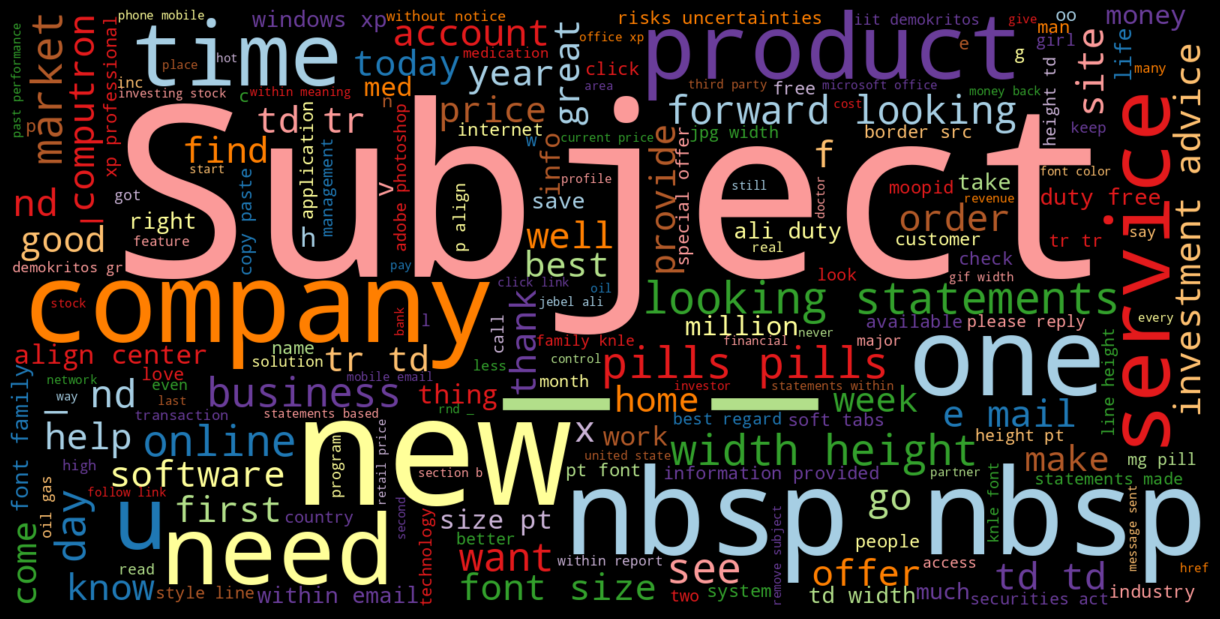

In [ ]:
from wordcloud import WordCloud
benign_url = " ".join(i for i in df_spam.text)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(benign_url)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

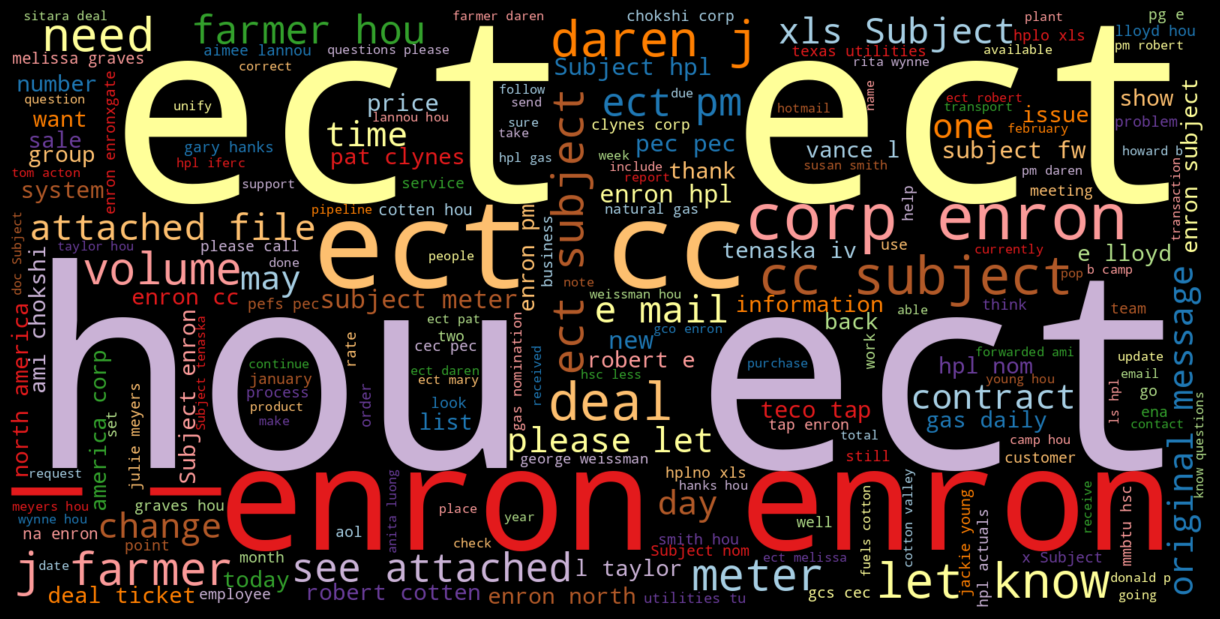

In [ ]:
ham_text = " ".join(i for i in df_ham.text)
wordcloud = WordCloud(width=1600, height=800,colormap='Paired').generate(ham_text)
plt.figure( figsize=(12,14),facecolor='k')
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()

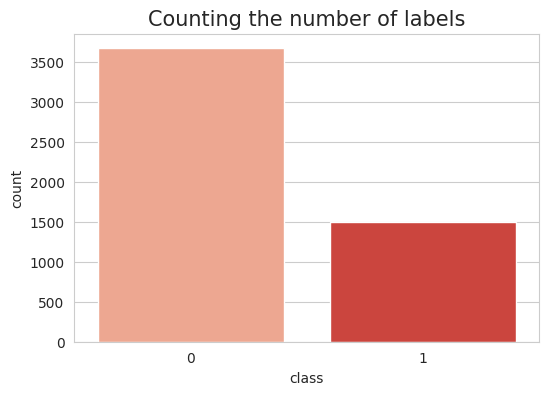

In [ ]:
plt.figure(figsize = (6, 4))
plt.title("Counting the number of labels",fontsize=15)
sns.countplot(data = df,palette= 'Reds', x = 'class');

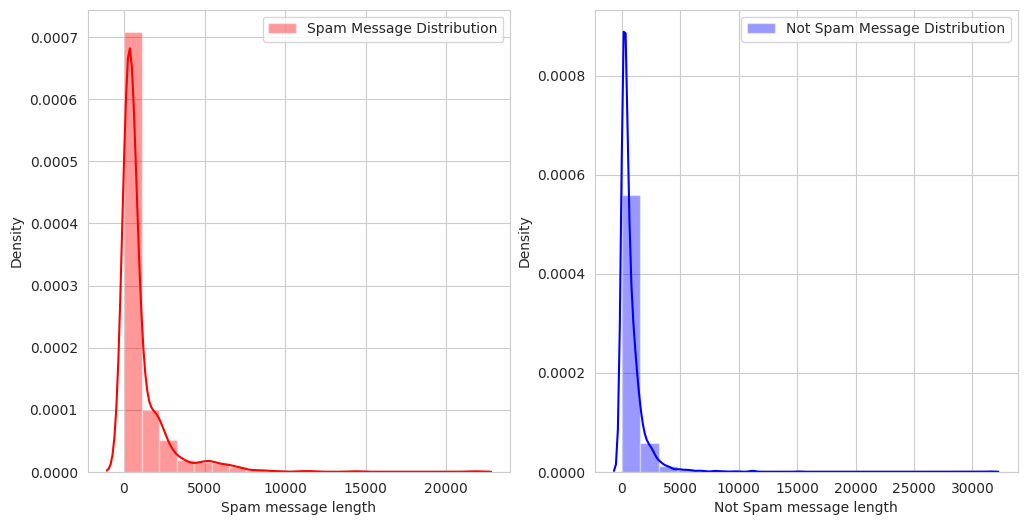

In [ ]:
# Importing the warnings
import warnings
warnings.filterwarnings('ignore')
df['length'] = df.text.str.len()

#Message distribution before cleaning
f,ax = plt.subplots(1,2,figsize=(12,6))

sns.distplot(df[df['class']==1]['length'],bins=20, ax=ax[0],label='Spam Message Distribution',color='r')
ax[0].set_xlabel('Spam message length')
ax[0].legend()

sns.distplot(df[df['class']==0]['length'],bins=20, ax=ax[1],label='Not Spam Message Distribution',color='b')
ax[1].set_xlabel('Not Spam message length')
ax[1].legend()

plt.show()

## Remove stopwords from the data

In [ ]:
%%time
stop_words = set(stopwords.words('english')) 

df['text'] = df['text'].apply(lambda x: ' '.join([ word for word in word_tokenize(x)  if not word in stop_words]))

CPU times: user 8.14 s, sys: 32.2 ms, total: 8.17 s
Wall time: 10.4 s


In [ ]:
df.sample(10)

,label,text,class
3604,ham,"Subject : sanchez oil & gas - 20 , 000 / , har...",0
1735,ham,"Subject : enron / hpl actuals june 23 - 25 , 2...",0
4739,spam,Subject : relax muscle world ' smallest massag...,1
4311,ham,Subject : organization announcement enron purc...,0
3046,ham,Subject : 1 / 2000 meter 9643 three rivers iss...,0
4711,spam,Subject : communion chimique genuric ciilis ( ...,1
519,ham,"Subject : enron / hpl actuals december 12 , 20...",0
1287,ham,Subject : new storage flag earliest convenienc...,0
2922,ham,Subject : oasis / hpl interconnect 6780 cuts f...,0
2801,ham,Subject : natural gas nomination december 2000...,0


In [ ]:
X = df.loc[:, 'text']
y = df.loc[:, 'class']

print(f"Shape of X: {X.shape}\nshape of y: {y.shape}")

Shape of X: (5171,)
shape of y: (5171,)


## Split data into **train** and **test** in 80:20

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=11)

In [ ]:
print(f"Train Data Shape: {X_train.shape}\nTest Data Shape: {X_test.shape}")

Train Data Shape: (4136,)
Test Data Shape: (1035,)


## Preprocess text to build the ML mdel

In [ ]:
cVect = CountVectorizer()
cVect.fit(X_train)

CountVectorizer()

  Let's see the vocabulary that has extracted by hte count vextorizer

In [ ]:
print('NO.of Tokens: ',len(cVect.vocabulary_.keys()))

NO.of Tokens:  44255


In [ ]:
# document term vector (dtv)
dtv = cVect.transform(X_train)

In [ ]:
type(dtv)

scipy.sparse._csr.csr_matrix

In [ ]:
dtv = dtv.toarray()

In [ ]:
print(f"Number of Observations: {dtv.shape[0]}\nTokens/Features: {dtv.shape[1]}")

Number of Observations: 4136
Tokens/Features: 44255


In [ ]:
# Let's see an sample that has been preprocessed
dtv[1]

array([0, 0, 0, ..., 0, 0, 0])

### Hyperparameter Tuning

In [ ]:
lr = LogisticRegression(verbose=1)

grid={"C":[float(i) for i in range(1, 3)], "penalty":["l2"], "solver":[ 'lbfgs', 'liblinear']}
logreg_cv=GridSearchCV(lr, grid, cv=4)
logreg_cv.fit(dtv,y_train)

print("Tuned Hpyerparameters :",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   16.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.5s finished


[LibLinear][LibLinear][LibLinear][LibLinear]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.5s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   15.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   14.7s finished


[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Tuned Hpyerparameters : {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
accuracy : 0.9765473887814313


In [ ]:
%%time
lr = LogisticRegression(solver='liblinear', penalty ='l2' , C = 1.0)
lr.fit(dtv, y_train)

CPU times: user 1.25 s, sys: 609 ms, total: 1.86 s
Wall time: 1.48 s


LogisticRegression(solver='liblinear')

## Evaluate on the Test data

In [ ]:
# Preprocess the test data
test_dtv = cVect.transform(X_test)
test_dtv = test_dtv.toarray()
print(f"Number of Observations: {test_dtv.shape[0]}\nTokens/Features: {test_dtv.shape[1]}")

Number of Observations: 1035
Tokens/Features: 44255


In [ ]:
%%time
pred = lr.predict(test_dtv)

CPU times: user 97.4 ms, sys: 98.8 ms, total: 196 ms
Wall time: 171 ms


In [ ]:
print('Accuracy: ', accuracy_score(y_test, pred) * 100)

Accuracy:  98.35748792270532


  Classification Report of the classifier

In [ ]:
# 0 - Not Spam / Ham
# 1 - Spam 
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       744
           1       0.95      0.99      0.97       291

    accuracy                           0.98      1035
   macro avg       0.97      0.99      0.98      1035
weighted avg       0.98      0.98      0.98      1035



  Confusion Matrix

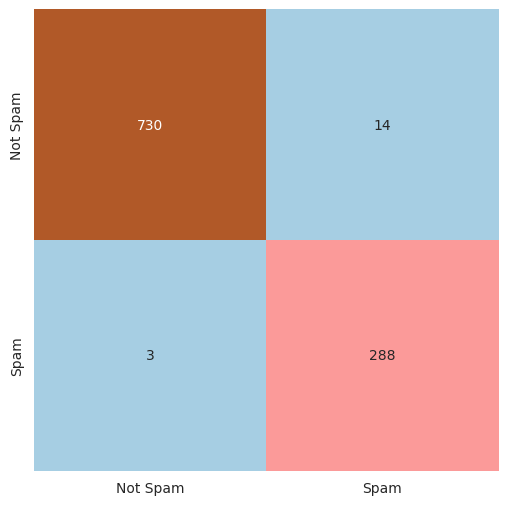

In [ ]:
cmat = confusion_matrix(y_test, pred)
plt.figure(figsize = (6, 6))
sns.heatmap(cmat, annot = True, cmap = 'Paired', cbar = False, fmt="d", xticklabels=['Not Spam', 'Spam'], yticklabels=['Not Spam', 'Spam']);

## Predict Class label for the unseen data i.e., Spam or Not Spam

In [ ]:
# 'You won 1000$ prize money in lottery. Click here to avail'
def predict_class(lr):
    text = input('Enter Text (Subject of the mail) : ')
    text = [' '.join([ word for word in word_tokenize(text)  if not word in stop_words])]
    t_dtv = cVect.transform(text).toarray()
    print('Predicted Class:', end = ' ')
    print('Spam' if lr.predict(t_dtv)[0] else 'Not Spam') 
    prob = lr.predict_proba(t_dtv)*100
    print(f"Not Spam: {prob[0][0]}%\nSpam: {prob[0][1]}%")
    plt.figure(figsize=(12, 6))
    sns.barplot(x =['Not Spam', 'Spam'] , y = [prob[0][0], prob[0][1]])
    plt.xlabel('Class')
    plt.ylabel('Probalility')
    plt.show()

Enter Text(Subject of the mail): You have won lottery $1000
Predicted Class: Spam
Not Spam: 29.197488855599417%
Spam: 70.80251114440058%


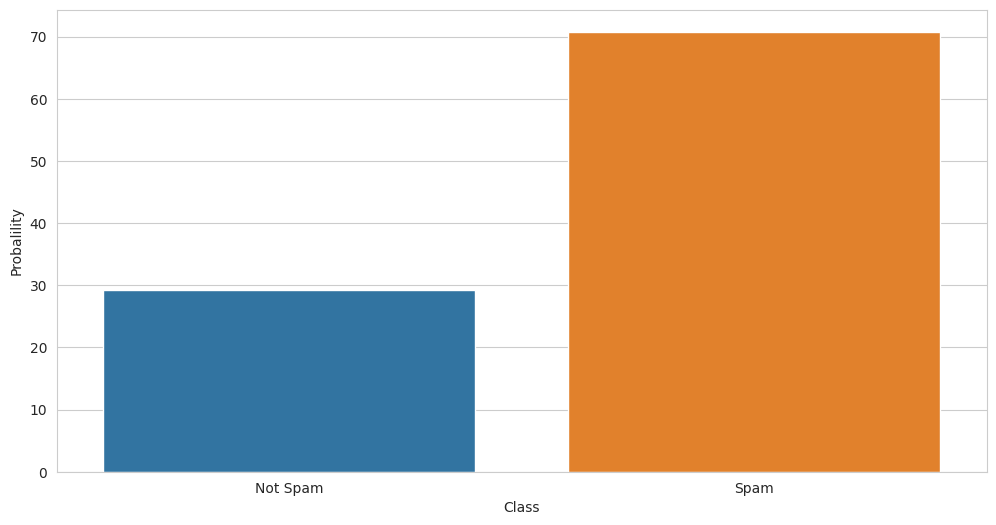

In [ ]:
predict_class(lr)



---

